In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 6.0)

import numpy as np
import math
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

Using TensorFlow backend.


In [2]:
from bokeh.plotting import output_file, show, figure
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
dataset = pd.read_csv('724940_all.csv')
dataset.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (deg),Azimuth (deg),ETR (W/m^2),ETRN (W/m^2),Glo Mod (W/m^2),Glo Mod Unc (%),Glo Mod Source,Dir Mod (W/m^2),Dir Mod Unc (%),Dir Mod Source,Dif Mod (W/m^2),Dif Mod Unc (%),Dif Mod Source,Meas Glo (W/m^2),Meas Glo Flg,Meas Dir (W/m^2),Meas Dir Flg,Meas Dif (W/m^2),Meas Dif Flg,TotCC (10ths),Precip Wat (cm),Precip Wat Flg,AOD (unitless),AOD Flg
0,1991-01-01,1:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,6,0.70000,1,0.10800,1
1,1991-01-01,2:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.70000,1,0.10800,1
2,1991-01-01,3:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.80000,1,0.10800,1
3,1991-01-01,4:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.80000,1,0.10800,1
4,1991-01-01,5:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.80000,1,0.10800,1


In [4]:
dataset.loc[0, :]

YYYY-MM-DD          1991-01-01
HH:MM (LST)               1:00
Zenith (deg)          99.00000
Azimuth (deg)        -99.00000
ETR (W/m^2)                  0
ETRN (W/m^2)                 0
Glo Mod (W/m^2)              0
Glo Mod Unc (%)              0
Glo Mod Source               1
Dir Mod (W/m^2)              0
Dir Mod Unc (%)              0
Dir Mod Source               1
Dif Mod  (W/m^2)             0
Dif Mod Unc (%)              0
Dif Mod Source               1
Meas Glo (W/m^2)         -9900
Meas Glo Flg                99
Meas Dir (W/m^2)         -9900
Meas Dir Flg                99
Meas Dif (W/m^2)         -9900
Meas Dif Flg                99
TotCC (10ths)                6
Precip Wat (cm)        0.70000
Precip Wat Flg               1
AOD (unitless)         0.10800
AOD Flg                      1
Name: 0, dtype: object

## Preprocess dataframe and select the features

In [5]:
# To preprocess the data frame and caculate the GHI
def preprocess(df):
    # Select columns
    df = df.loc[:, ['YYYY-MM-DD', 'HH:MM (LST)', 'Zenith (deg)', 'Dir Mod (W/m^2)', \
                    'Dif Mod  (W/m^2)', 'Meas Dir (W/m^2)', 'Meas Dif (W/m^2)',
                    'Precip Wat (cm)', 'AOD (unitless)']]
    
    # Convert degree to radian
    df['Zenith (deg)'] = df['Zenith (deg)'].apply(math.radians)
    df = df.rename({'Zenith (deg)': 'Zenith (rad)'}, axis = 1)
    
    # Calculate GHI
    df['GHI'] = df['Dif Mod  (W/m^2)'].astype('float') + \
                df['Dir Mod (W/m^2)']. astype('float') * df['Zenith (rad)'].apply(math.cos)

    return df

In [6]:
dataset_post = preprocess(dataset)
dataset_post.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),Precip Wat (cm),AOD (unitless),GHI
0,1991-01-01,1:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
1,1991-01-01,2:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
2,1991-01-01,3:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
3,1991-01-01,4:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
4,1991-01-01,5:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000


In [7]:
dataset_post.tail()

,YYYY-MM-DD,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),Precip Wat (cm),AOD (unitless),GHI
131491,2005-12-31,20:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131492,2005-12-31,21:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131493,2005-12-31,22:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131494,2005-12-31,23:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131495,2005-12-31,24:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000


In [8]:
dataset_post['YYYY-MM-DD'] = pd.to_datetime(dataset_post['YYYY-MM-DD'])  
dataset_post = dataset_post.rename({'YYYY-MM-DD':'Datetime'}, axis = 1)
dataset_post.head()

,Datetime,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),Precip Wat (cm),AOD (unitless),GHI
0,1991-01-01,1:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
1,1991-01-01,2:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
2,1991-01-01,3:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
3,1991-01-01,4:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
4,1991-01-01,5:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000


In [9]:
daily = dataset_post.groupby('Datetime')
daily_data = daily['Datetime', 'GHI', 'Precip Wat (cm)', 'AOD (unitless)'].mean()

In [10]:
daily_data.head()

,GHI,Precip Wat (cm),AOD (unitless)
Datetime,,,
1991-01-01,95.99922,0.82500,0.10233
1991-01-02,79.88263,1.00000,0.10283
1991-01-03,66.10387,1.15417,0.09408
1991-01-04,104.28998,1.11250,0.08858
1991-01-05,92.72703,1.00000,0.13192


In [11]:
daily_data = daily_data.rename({'Precip Wat (cm)':'Precip_water', 'AOD (unitless)':'AOD'}, axis = 1)
daily_data.head()

,GHI,Precip_water,AOD
Datetime,,,
1991-01-01,95.99922,0.82500,0.10233
1991-01-02,79.88263,1.00000,0.10283
1991-01-03,66.10387,1.15417,0.09408
1991-01-04,104.28998,1.11250,0.08858
1991-01-05,92.72703,1.00000,0.13192


In [12]:
daily_data.index

DatetimeIndex(['1991-01-01', '1991-01-02', '1991-01-03', '1991-01-04',
               '1991-01-05', '1991-01-06', '1991-01-07', '1991-01-08',
               '1991-01-09', '1991-01-10',
               ...
               '2005-12-22', '2005-12-23', '2005-12-24', '2005-12-25',
               '2005-12-26', '2005-12-27', '2005-12-28', '2005-12-29',
               '2005-12-30', '2005-12-31'],
              dtype='datetime64[ns]', name=u'Datetime', length=5479, freq=None)

In [22]:
daily_ts = daily_data.astype('d')
daily_ts.index

DatetimeIndex(['1991-01-01', '1991-01-02', '1991-01-03', '1991-01-04',
               '1991-01-05', '1991-01-06', '1991-01-07', '1991-01-08',
               '1991-01-09', '1991-01-10',
               ...
               '2005-12-22', '2005-12-23', '2005-12-24', '2005-12-25',
               '2005-12-26', '2005-12-27', '2005-12-28', '2005-12-29',
               '2005-12-30', '2005-12-31'],
              dtype='datetime64[ns]', name=u'Datetime', length=5479, freq=None)

### Use month as a feature

In [23]:
daily_ts.index[100].month

4

In [24]:
daily_ts['Month'] = daily_ts.index.month

In [25]:
daily_ts.head()

,GHI,Precip_water,AOD,Month
Datetime,,,,
1991-01-01,95.99922,0.82500,0.10233,1
1991-01-02,79.88263,1.00000,0.10283,1
1991-01-03,66.10387,1.15417,0.09408,1
1991-01-04,104.28998,1.11250,0.08858,1
1991-01-05,92.72703,1.00000,0.13192,1


In [26]:
daily_ts = daily_ts.loc['2001':'2005']

In [27]:
daily_ts.head()

,GHI,Precip_water,AOD,Month
Datetime,,,,
2001-01-01,108.83462,0.81667,0.10800,1
2001-01-02,103.79000,0.93750,0.10800,1
2001-01-03,108.79913,0.94583,0.10800,1
2001-01-04,109.80042,0.80417,0.10800,1
2001-01-05,101.97893,0.73750,0.10800,1


In [28]:
p = figure(width=800, height=350, x_axis_type="datetime")

# add renderers
p.line(daily_ts.index, daily_ts.GHI, color='navy', legend='GHI')
show(p)

In [29]:
p = figure(width=800, height=350, x_axis_type="datetime")

# add renderers
p.line(daily_ts.index, daily_ts.Precip_water, color='navy', legend='Precip Water')
show(p)

In [30]:
p = figure(width=800, height=350, x_axis_type="datetime")

# add renderers
p.line(daily_ts.index, daily_ts.AOD, color='navy', legend='Precip Water')
show(p)

### Add previous 5 lags of GHI as feature

In [31]:
for lags in range(1,6):
    daily_ts["T_" + str(lags)] = daily_ts.GHI.shift(lags)

In [32]:
daily_ts.fillna(0.00,inplace=True)
daily_ts.head(10)

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5
Datetime,,,,,,,,,
2001-01-01,108.83462,0.81667,0.10800,1,0.00000,0.00000,0.00000,0.00000,0.00000
2001-01-02,103.79000,0.93750,0.10800,1,108.83462,0.00000,0.00000,0.00000,0.00000
2001-01-03,108.79913,0.94583,0.10800,1,103.79000,108.83462,0.00000,0.00000,0.00000
2001-01-04,109.80042,0.80417,0.10800,1,108.79913,103.79000,108.83462,0.00000,0.00000
2001-01-05,101.97893,0.73750,0.10800,1,109.80042,108.79913,103.79000,108.83462,0.00000
2001-01-06,111.79378,0.88750,0.10800,1,101.97893,109.80042,108.79913,103.79000,108.83462
2001-01-07,28.78159,1.22083,0.10800,1,111.79378,101.97893,109.80042,108.79913,103.79000
2001-01-08,92.07880,1.06667,0.10800,1,28.78159,111.79378,101.97893,109.80042,108.79913
2001-01-09,29.10399,1.04167,0.10800,1,92.07880,28.78159,111.79378,101.97893,109.80042


## Build model without removing seasonality

In [66]:
training_data = daily_ts.loc['2001-01-01':'2004-12-31']
test_data = daily_ts.loc['2005-01-01':]

In [67]:
training_data.tail(3)

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5
Datetime,,,,,,,,,
2004-12-29,94.22950,1.58750,0.10800,12,27.54778,24.62325,27.97894,84.34618,105.32747
2004-12-30,38.89621,1.67500,0.10800,12,94.22950,27.54778,24.62325,27.97894,84.34618
2004-12-31,70.92448,1.46667,0.10800,12,38.89621,94.22950,27.54778,24.62325,27.97894


In [68]:
test_data.head(3)

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5
Datetime,,,,,,,,,
2005-01-01,64.82589,1.30000,0.10800,1,70.92448,38.89621,94.22950,27.54778,24.62325
2005-01-02,25.08333,1.43750,0.10800,1,64.82589,70.92448,38.89621,94.22950,27.54778
2005-01-03,63.51450,1.38333,0.10800,1,25.08333,64.82589,70.92448,38.89621,94.22950


### Random forest regressor model

In [69]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

In [70]:
X_train,y_train = training_data.drop(['GHI'], axis=1), training_data.GHI
X_test,y_test = test_data.drop(['GHI'], axis=1),test_data.GHI

In [71]:
print "train shape:", X_train.shape, y_train.shape
print "test shape:", X_test.shape, y_test.shape

train shape: (1461, 8) (1461,)
test shape: (365, 8) (365,)


In [72]:
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
rfr  = RandomForestRegressor(random_state=2017, n_estimators=15, verbose=2,n_jobs=10)

#### Normalize features

In [73]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [74]:
rfr.fit(X_train_scaled, y_train)

building tree 1 of 15
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15building tree 5 of 15

building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=10)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:    0.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=10,
           oob_score=False, random_state=2017, verbose=2, warm_start=False)

In [75]:
rfr.score(X_test ,y_test)

[Parallel(n_jobs=10)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:    0.0s finished


-0.36123580224788476

In [76]:
test_data["RF_PREDICTED"] = rfr.predict(X_test_scaled)

[Parallel(n_jobs=10)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:    0.0s finished
/Users/qianyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
test_data.head(5)

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5,RF_PREDICTED
Datetime,,,,,,,,,,
2005-01-01,64.82589,1.30000,0.10800,1,70.92448,38.89621,94.22950,27.54778,24.62325,107.12111
2005-01-02,25.08333,1.43750,0.10800,1,64.82589,70.92448,38.89621,94.22950,27.54778,125.89187
2005-01-03,63.51450,1.38333,0.10800,1,25.08333,64.82589,70.92448,38.89621,94.22950,132.84915
2005-01-04,78.13579,1.33333,0.10800,1,63.51450,25.08333,64.82589,70.92448,38.89621,114.03558
2005-01-05,32.27316,1.29583,0.10800,1,78.13579,63.51450,25.08333,64.82589,70.92448,125.38084


In [78]:
predict_p = figure(width=900, height=350, x_axis_type="datetime")

# add renderers
predict_p.line(test_data.index, y=test_data.GHI, color = 'blue', legend='Test Data')
predict_p.line(test_data.index, y=test_data.RF_PREDICTED, color = 'red', legend='Predict')
show(predict_p)

###  Use Root Mean Square Error to measure the model accuracy

In [79]:
RMSE = np.sqrt(mean_squared_error(test_data.GHI, test_data.RF_PREDICTED))
print "Random Forrest Regressor Model RMSE : {:.5f}".format(RMSE)

Random Forrest Regressor Model RMSE : 56.15974


### LSTM Model

In [80]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 8)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

#### Reshape data into 3-D

In [81]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [82]:
hist = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 8s - loss: 41434.9944
Epoch 2/100
 - 6s - loss: 38764.4702
Epoch 3/100
 - 5s - loss: 36725.8700
Epoch 4/100
 - 6s - loss: 34959.4883
Epoch 5/100
 - 6s - loss: 33305.2490
Epoch 6/100
 - 5s - loss: 31720.4504
Epoch 7/100
 - 5s - loss: 30205.1756
Epoch 8/100
 - 5s - loss: 28748.8256
Epoch 9/100
 - 6s - loss: 27361.0041
Epoch 10/100
 - 5s - loss: 26037.3357
Epoch 11/100
 - 5s - loss: 24777.3747
Epoch 12/100
 - 6s - loss: 23578.2053
Epoch 13/100
 - 5s - loss: 22433.0998
Epoch 14/100
 - 6s - loss: 21342.2610
Epoch 15/100
 - 5s - loss: 20308.4943
Epoch 16/100
 - 5s - loss: 19327.7277
Epoch 17/100
 - 6s - loss: 18382.1642
Epoch 18/100
 - 5s - loss: 17485.8636
Epoch 19/100
 - 5s - loss: 16638.5599
Epoch 20/100
 - 6s - loss: 15829.5090
Epoch 21/100
 - 5s - loss: 15063.0389
Epoch 22/100
 - 5s - loss: 14337.6706
Epoch 23/100
 - 5s - loss: 13643.2273
Epoch 24/100
 - 6s - loss: 12984.6892
Epoch 25/100
 - 5s - loss: 12359.5280
Epoch 26/100
 - 6s - loss: 11766.6704
Epoch 27/100
 - 6s - 

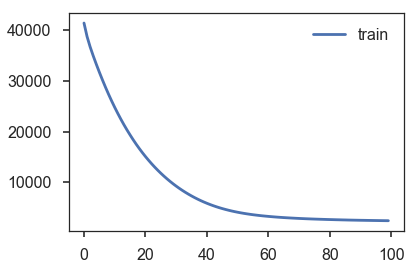

In [84]:
plt.plot(hist.history['loss'], label='train')
plt.legend()

In [85]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [86]:
res = model.predict(X_te_reshaped)
test_data["LSTM_PRED"] = res

/Users/qianyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
test_data.head()

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5,RF_PREDICTED,LSTM_PRED
Datetime,,,,,,,,,,,
2005-01-01,64.82589,1.30000,0.10800,1,70.92448,38.89621,94.22950,27.54778,24.62325,107.12111,86.56068
2005-01-02,25.08333,1.43750,0.10800,1,64.82589,70.92448,38.89621,94.22950,27.54778,125.89187,84.51300
2005-01-03,63.51450,1.38333,0.10800,1,25.08333,64.82589,70.92448,38.89621,94.22950,132.84915,89.73108
2005-01-04,78.13579,1.33333,0.10800,1,63.51450,25.08333,64.82589,70.92448,38.89621,114.03558,86.58462
2005-01-05,32.27316,1.29583,0.10800,1,78.13579,63.51450,25.08333,64.82589,70.92448,125.38084,87.38631


In [88]:
keras_p = figure(width=900, height=350, x_axis_type="datetime")

# add renderers
keras_p.line(test_data.index, y=test_data.GHI, color = 'blue', legend='Test Data')
keras_p.line(test_data.index, y=test_data.RF_PREDICTED, color = 'red', legend='RF_Predict')
keras_p.line(test_data.index, y=test_data.LSTM_PRED, color = 'green', legend='LSTM_predict')
show(keras_p)

In [89]:
RMSE_lstm = np.sqrt(mean_squared_error(test_data.GHI, test_data.LSTM_PRED))
print "LSTM Model RMSE : {:.5f}".format(RMSE_lstm)

LSTM Model RMSE : 50.82688
